In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import pickle

In [3]:
list_of_files = ['PAMAP2_Dataset/Protocol/subject101.dat',
                 'PAMAP2_Dataset/Protocol/subject102.dat',
                 'PAMAP2_Dataset/Protocol/subject103.dat',
                 'PAMAP2_Dataset/Protocol/subject104.dat',
                 'PAMAP2_Dataset/Protocol/subject105.dat',
                 'PAMAP2_Dataset/Protocol/subject106.dat',
                 'PAMAP2_Dataset/Protocol/subject107.dat',
                 'PAMAP2_Dataset/Protocol/subject108.dat',
                 'PAMAP2_Dataset/Protocol/subject109.dat' ]

subjectID = [1, 2, 3, 4, 5, 6, 7, 8, 9]

activityIDdict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle

In [4]:
dataCollection = pd.DataFrame()
for file in list_of_files:
    procData = pd.read_table(file, header=None, sep='\s+')
    procData.columns = columns
    procData['subject_id'] = int(file[-5])
    dataCollection = pd.concat((dataCollection, procData), ignore_index=True)

dataCollection.reset_index(drop=True, inplace=True)

In [5]:
activityID = [3, 4, 5, 6]

def dataCleaning(dataCollection, selected_features):
        dataCollection = dataCollection[selected_features]
        for i in list(activityIDdict.keys()):
            if i not in activityID:
                dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == i].index)
        dataCollection = dataCollection.interpolate()
        return dataCollection

In [6]:
selected_features = ['activityID', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'subject_id']

dataCol = dataCleaning(dataCollection, selected_features)
dataCol.reset_index(drop=True, inplace=True)

In [7]:
all_velocities = []

targets = []

for user_id in subjectID:
    for activity_id in activityID:
        df = dataCol.loc[(dataCol.subject_id == user_id) & (dataCol.activityID == activity_id)]
        velocities = df[['ankleGyro1', 'ankleGyro2', 'ankleGyro3']].to_numpy()
        
        l = len(velocities) // 500
        
        if l > 0:
            for sub_trajectory in np.array_split(velocities, l, axis = 0):
                all_velocities.append(sub_trajectory)
                targets.append(activity_id)

In [8]:
tau = 0.01

def vel2coord(vel_components):
    
    coords = [[tau / 3 * (vel_arr[i - 1] + 4 * vel_arr[i] + vel_arr[i + 1]) for i in range(1, len(vel_arr) - 1)] \
                for vel_arr in vel_components.T]
    return np.array(coords).T

def vel2acc(vel_components):
    
    accels = [[(vel_arr[i + 1] - vel_arr[i - 1]) / (2 * tau) for i in range(1, len(vel_arr) - 1)] \
                for vel_arr in vel_components.T]
    return np.array(accels).T

def vel_cut(vel_components):
    return vel_components[1 : (-1)]


def form_trajectory(vel_components, name):
    
    x_train = np.hstack((vel2coord(vel_components), vel_cut(vel_components)))
    y_train = np.hstack((vel_cut(vel_components), vel2acc(vel_components)))
    
    with open(Path("trajectories", name), 'wb') as handle:
        pickle.dump([x_train, y_train], handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def form_all_trajectories(multiple_vel_arrs, experiment_name):
    
    for i in tqdm(range(len(multiple_vel_arrs))):
        
        vel_components = multiple_vel_arrs[i]
        
        name = experiment_name + '_' + str(i + 1) + '.pickle'
        form_trajectory(vel_components, name)

In [39]:
form_all_trajectories(all_velocities, 'experiment1')

100%|██████████████████████████████████████| 1372/1372 [00:03<00:00, 392.43it/s]


In [9]:
id_list = range(0, 1299)

x_arr = []

for i in id_list:
    with open(Path("logs", f"lnn_model_experiment2_{i + 1}.pickle"), 'rb') as f:
         x_arr.append(np.array(pickle.load(f)))
            
X = np.array(x_arr)
y = np.array(targets[0:1299])

In [10]:
random_state = 124

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

In [11]:
pca_instance = PCA(2)

X_train_transformed = pca_instance.fit_transform(X_train)
X_test_transformed = pca_instance.transform(X_test)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


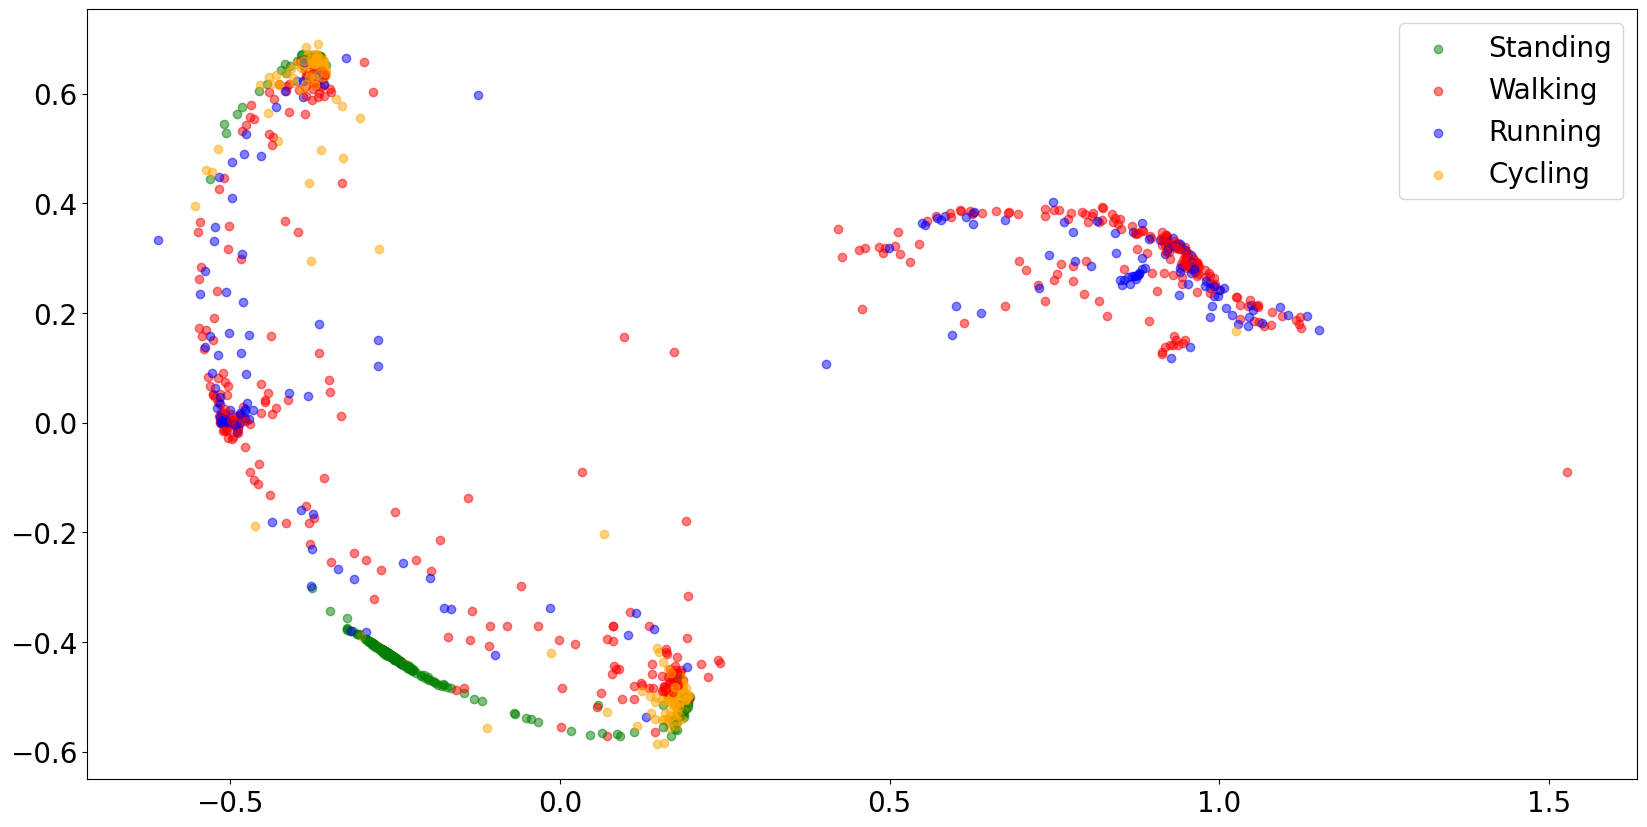

In [12]:
plt.figure(figsize = (20, 10))

X_standing = X_train_transformed[np.where(y_train == 3)]
X_walking = X_train_transformed[np.where(y_train == 4)]
X_running = X_train_transformed[np.where(y_train == 5)]
X_cycling = X_train_transformed[np.where(y_train == 6)]

X_standing_test = X_test_transformed[np.where(y_test == 3)]
X_walking_test = X_test_transformed[np.where(y_test == 4)]
X_running_test = X_test_transformed[np.where(y_test == 5)]
X_cycling_test = X_test_transformed[np.where(y_test == 6)]

plt.scatter(X_standing[:, 0], X_standing[:, 1], alpha = 0.5, color = "green", label = "Standing")
plt.scatter(X_walking[:, 0], X_walking[:, 1], alpha = 0.5, color = 'red', label = "Walking")
plt.scatter(X_running[:, 0], X_running[:, 1], alpha = 0.5, color = 'blue', label = "Running")
plt.scatter(X_cycling[:, 0], X_cycling[:, 1], alpha = 0.5, color = 'orange', label = "Cycling")

plt.scatter(X_standing_test[:, 0], X_standing_test[:, 1], alpha = 0.5, color = "green")
plt.scatter(X_walking_test[:, 0], X_walking_test[:, 1], alpha = 0.5, color = 'red')
plt.scatter(X_running_test[:, 0], X_running_test[:, 1], alpha = 0.5, color = 'blue')
plt.scatter(X_cycling_test[:, 0], X_cycling_test[:, 1], alpha = 0.5, color = 'orange')

plt.legend(fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(Path("figures", "Data_2D.eps"))
plt.show()

In [13]:
pca_instance = PCA(3)

X_train_transformed = pca_instance.fit_transform(X_train)
X_test_transformed = pca_instance.transform(X_test)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


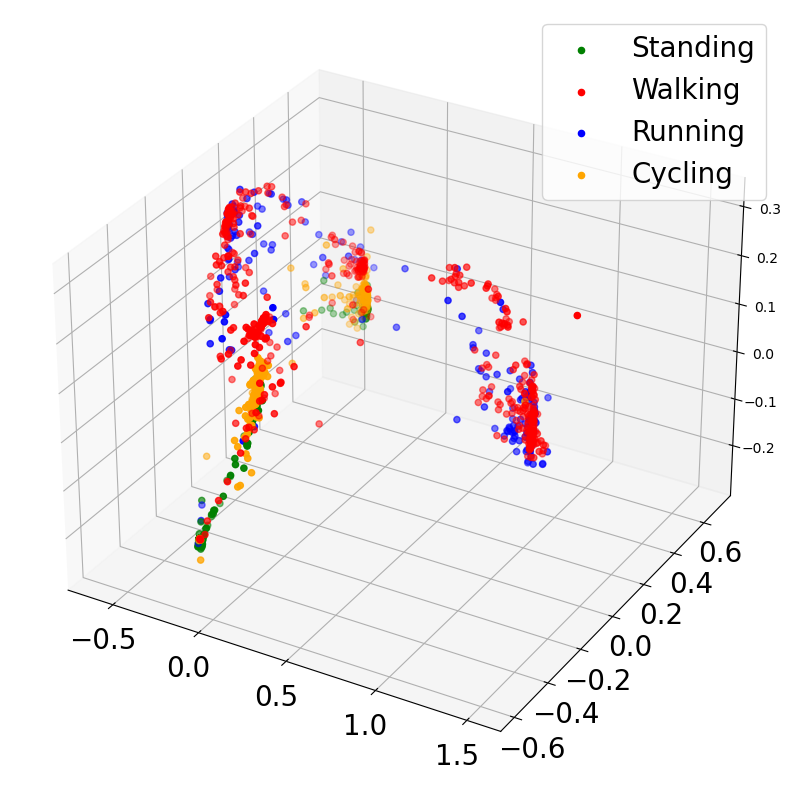

In [18]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

X_standing = X_train_transformed[np.where(y_train == 3)]
X_walking = X_train_transformed[np.where(y_train == 4)]
X_running = X_train_transformed[np.where(y_train == 5)]
X_cycling = X_train_transformed[np.where(y_train == 6)]

X_standing_test = X_test_transformed[np.where(y_test == 3)]
X_walking_test = X_test_transformed[np.where(y_test == 4)]
X_running_test = X_test_transformed[np.where(y_test == 5)]
X_cycling_test = X_test_transformed[np.where(y_test == 6)]

ax.scatter(X_standing[:, 0], X_standing[:, 1], X_standing[:, 2], color="green", label = "Standing")
ax.scatter(X_walking[:, 0], X_walking[:, 1], X_walking[:, 2], color="red", label = "Walking")
ax.scatter(X_running[:, 0], X_running[:, 1], X_running[:, 2], color="blue", label = "Running")
ax.scatter(X_cycling[:, 0], X_cycling[:, 1], X_cycling[:, 2], color="orange", label = "Cycling")

ax.scatter(X_standing_test[:, 0], X_standing_test[:, 1], X_standing_test[:, 2], alpha = 0.5, color = "green")
ax.scatter(X_walking_test[:, 0], X_walking_test[:, 1], X_walking_test[:, 2], alpha = 0.5, color = 'red')
ax.scatter(X_running_test[:, 0], X_running_test[:, 1], X_running_test[:, 2], alpha = 0.5, color = 'blue')
ax.scatter(X_cycling_test[:, 0], X_cycling_test[:, 1], X_cycling_test[:, 2], alpha = 0.5, color = 'orange')

plt.legend(fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(Path("figures", "Data_3D.eps"))
plt.show()

In [39]:
pca_instance = PCA(20)

X_train_transformed = pca_instance.fit_transform(X_train)
X_test_transformed = pca_instance.transform(X_test)

In [34]:
regression = LogisticRegression(C=1.0)
regression.fit(X_train_transformed, y_train)

y_pred = regression.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

In [40]:
gpc = GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=random_state)
gpc.fit(X_train_transformed, y_train)

y_pred = gpc.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

In [37]:
forest = RandomForestClassifier(n_estimators=1000)
forest.fit(X_train_transformed, y_train)

y_pred = forest.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

In [41]:
print(acc_score)

0.85


In [20]:
x = []
y_1 = []
y_2 = []
y_3 = []
for i in tqdm(range(2, 30)):
    pca_instance = PCA(i)

    X_train_transformed = pca_instance.fit_transform(X_train)
    X_test_transformed = pca_instance.transform(X_test)
    
    regression = LogisticRegression(C=1.0)
    regression.fit(X_train_transformed, y_train)
    
    gpc = GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=random_state)
    gpc.fit(X_train_transformed, y_train)
    
    forest = RandomForestClassifier(n_estimators=1000)
    forest.fit(X_train_transformed, y_train)

    y_pred_1 = regression.predict(X_test_transformed)
    acc_score_1 = accuracy_score(y_test, y_pred_1)
    y_1.append(acc_score_1)
    
    y_pred_2 = gpc.predict(X_test_transformed)
    acc_score_2 = accuracy_score(y_test, y_pred_2)
    y_2.append(acc_score_2)
    
    y_pred_3 = forest.predict(X_test_transformed)
    acc_score_3 = accuracy_score(y_test, y_pred_3)
    y_3.append(acc_score_3)
    
    x.append(i)

100%|███████████████████████████████████████████| 28/28 [10:43<00:00, 22.97s/it]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


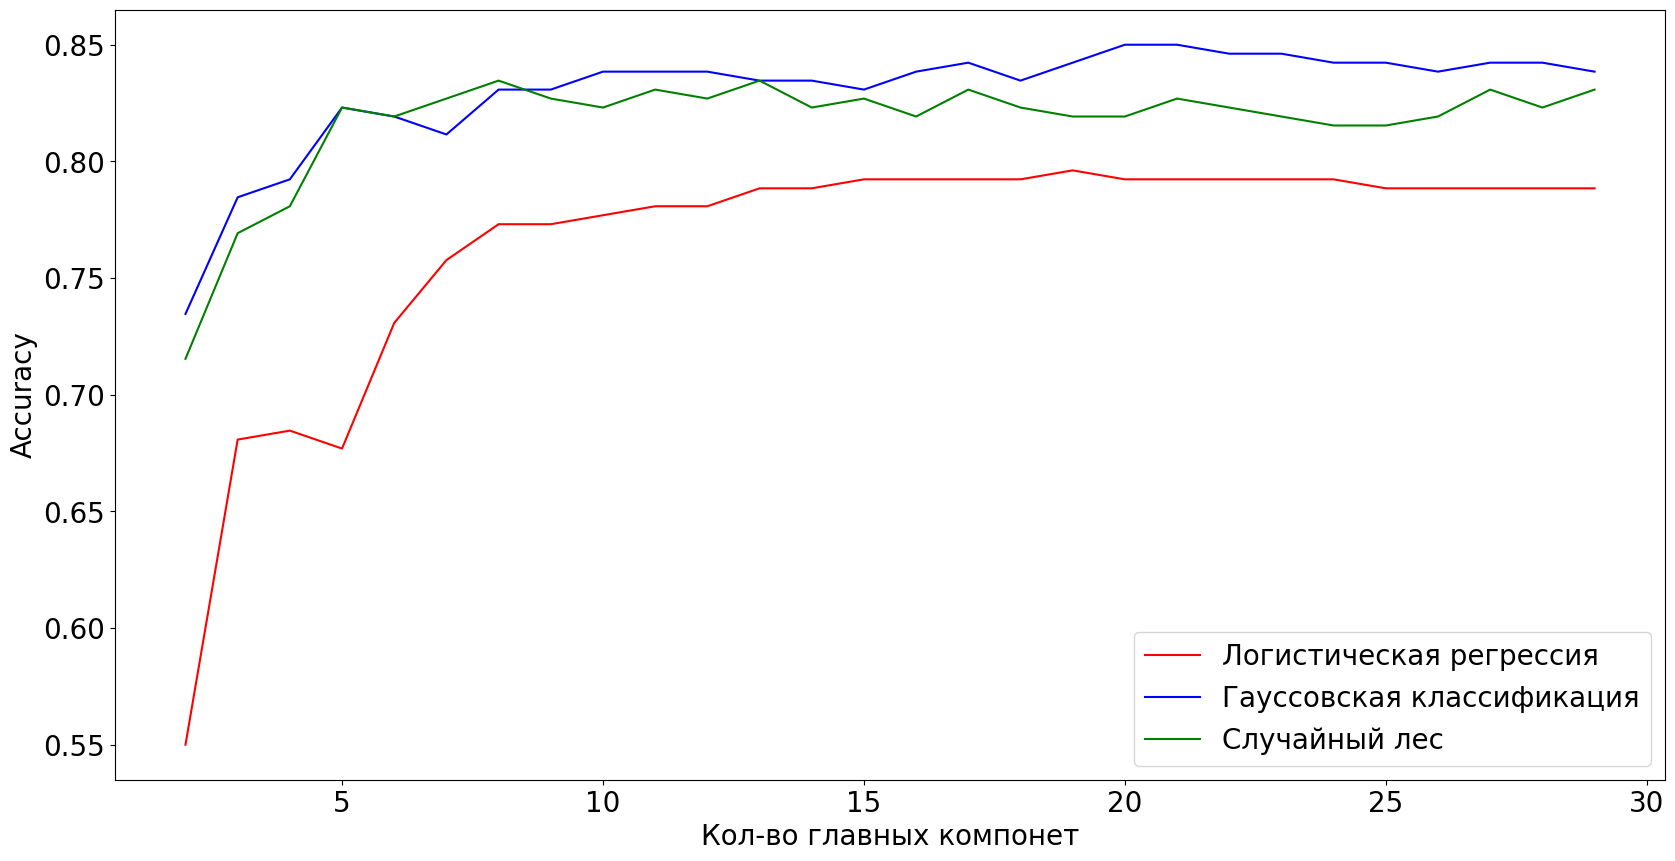

In [42]:
plt.figure(figsize = (20, 10))
plt.plot(x, y_1, color="red", label = "Логистическая регрессия")
plt.plot(x, y_2, color="blue", label = "Гауссовская классификация")
plt.plot(x, y_3, color="green", label = "Случайный лес")
plt.xlabel("Кол-во главных компонет", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend(fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(Path("figures", "Accuracy.eps"))
plt.show()